## 00: Import Modules and Set Hyper-parameters

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100 # num of embedding feature dimensions (like RGB for image)
max_length = 16 # max length of a sentence
trunc_type='post' # truncate end words
padding_type='post' # pad in the end
oov_tok = "<OOV>" # out-of-value token
training_size=160000 
test_portion=.1 # 10% data for test

corpus = []


## 01: Prepare Data

We first download data and extract sentences and labels

In [2]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-20 15:12:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  70.3MB/s    in 3.2s    

2020-08-20 15:12:36 (70.3 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0': # binary class
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


Have a look at the sentences.

In [30]:
print(num_sentences)
print(len(corpus))
print(corpus[0])

1600000
1600000
['@MilkyMooMoo Oh no, my old mum wont let me use the phone on mondays and certainly not to ring a pretty lady like you! ', 1]


Prepare training data.

In [5]:
# create sentences and labels
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

# tokenize the sentences: word --> index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index) # num of different words

sequences = tokenizer.texts_to_sequences(sentences) # transfer a sentence to an index sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # form all sentence sequences to the same length

# split the sequences to training and test
split = int(test_portion * training_size) 

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

## 02: Build model from transfer learning

We first download and generate Glove embedding model.

In [6]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-08-20 15:13:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  62.4MB/s    in 5.3s    

2020-08-20 15:13:08 (62.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [7]:
embeddings_index = {}
with open('/tmp/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim)); # storing the word embedding info
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

Then build the network model with both convolution and LSTM layers.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), # set parameters of pre-loaded embedding model untrainable
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13912200  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,977,353
Trainable params: 65,153
Non-trainable params: 13,912,200
_______________________________________

## 03: Training and Visualization

Before training, we have to transfer the senquences and labels into numpy arrays.

In [9]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 16s - loss: 0.5665 - accuracy: 0.6995 - val_loss: 0.5379 - val_accuracy: 0.7274
Epoch 2/50
4500/4500 - 15s - loss: 0.5254 - accuracy: 0.7333 - val_loss: 0.5205 - val_accuracy: 0.7404
Epoch 3/50
4500/4500 - 15s - loss: 0.5092 - accuracy: 0.7442 - val_loss: 0.5226 - val_accuracy: 0.7416
Epoch 4/50
4500/4500 - 15s - loss: 0.4984 - accuracy: 0.7527 - val_loss: 0.5139 - val_accuracy: 0.7457
Epoch 5/50
4500/4500 - 15s - loss: 0.4890 - accuracy: 0.7584 - val_loss: 0.5118 - val_accuracy: 0.7493
Epoch 6/50
4500/4500 - 15s - loss: 0.4815 - accuracy: 0.7635 - val_loss: 0.5091 - val_accuracy: 0.7524
Epoch 7/50
4500/4500 - 15s - loss: 0.4765 - accuracy: 0.7655 - val_loss: 0.5090 - val_accuracy: 0.7504
Epoch 8/50
4500/4500 - 15s - loss: 0.4712 - accuracy: 0.7701 - val_loss: 0.5136 - val_accuracy: 0.7489
Epoch 9/50
4500/4500 - 15s - loss: 0.4664 - accuracy: 0.7716 - val_loss: 0.5174 - val_accuracy: 0.7442
Epoch 10/50
4500/4500 - 15s - loss: 0.4629 - accuracy: 0.7745 - val_loss:

Let’s have a look at the training process, watching how accuracy and loss change over epochs.

<Figure size 432x288 with 0 Axes>

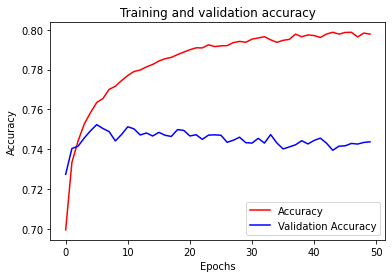

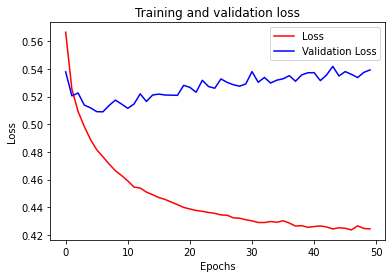

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

We can see that the training accuracy reaches up to 80%, which is quite good. However, there exists some kind of overfitting.

## 04: Use the model

Let's try this trained model to classify some sentences.

In [58]:
test_0 = ["I love you","I hate you","You're a good man, but we are not suitable to be together."]
test_1 = tokenizer.texts_to_sequences(test_0)
test_2 = pad_sequences(test_1, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_3 = np.array(test_2)
re = model.predict(test_3)
for i in range(len(re)):
  print(re[i])
  if re[i]>0.8:
    print('positive')
  elif re[i]<0.2:
    print('negative')

[0.88264596]
positive
[0.03774856]
negative
[0.24521422]


Both are classified correctly, the third is also reasonable. It's not bad:) 